# Global settings

In your root directory put the notebooks (*.ipynb) into a directory called "notebook/" and the R codes (*.R) into a directory called "Rcode/".

In [2]:
rootDir <- "/Users/calj/cur/teach/courses/astrostats_2017_ESAC/" # directory containing notebook, Rcode, and data directories

In [3]:
setwd(paste(rootDir, "Rcode", sep=""))
source("general_functions.R")
source("3Ddistvel_functions.R")
source("emcee.R")
setwd("../")
library(MASS) # for truehist

# Read GDR1 data and set parameter names

In [4]:
astromdat <- as.matrix( read.csv(paste(rootDir, "data/gdr1set02.csv", sep=""), sep=",")[,7:26] )
sourcenames <- read.csv(paste(rootDir, "data/gdr1set02.csv", sep=""), sep=",")[,"tycho2_id"]
astromdat[1:5,]

ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr
78.63819,0.8139856,30.11496,0.6448993,0.3544360,0.9808290,2.6473860,0.6317079,-4.3906009,0.8325771,-0.5399655,0.66411910,0.07259939,0.3160084,-0.7132095,-0.04754622,-0.1853941,0.16941312,0.29599650,0.01683142
79.35402,0.3881508,30.70396,0.3049907,1.7235501,0.2843546,2.6057483,1.3087594,-10.3624641,1.0488415,-0.7127338,0.31207666,-0.79693390,0.7672628,-0.5610968,0.64823335,-0.7207778,-0.11328893,0.23889863,-0.83865607
79.32288,0.5642119,30.66729,0.4436643,0.4696314,0.3569680,1.3445589,2.0993413,-2.5396095,1.6920335,-0.7939757,0.29751825,-0.84677804,0.8453941,-0.5206335,0.74195720,-0.8007249,-0.10762411,0.25307697,-0.89204144
78.95334,1.0023166,30.45902,0.7823597,1.3279830,0.4677145,4.9202770,3.1336298,-5.2718576,2.5936498,-0.8739407,-0.03278017,-0.87199193,0.8655612,-0.2653715,0.81387734,-0.8376483,0.05985344,0.03629664,-0.94297680
79.42229,0.2874400,30.82860,0.2514133,1.6021144,0.2714283,0.2040637,0.9422169,-0.3913075,0.7783015,-0.6129080,0.31847563,-0.74282320,0.7387190,-0.6734667,0.55096810,-0.6294726,-0.09860902,0.24733600,-0.77501510


In [5]:
phase3dnames <- c("distance", "speed", "angle")
boundaries <- list(NULL, NULL, c(0, 2*pi)) # periodic boundary conditions (if not NULL) on phase3d
astro3dnames <- c("parallax", "pmra", "pmdec") # used in code functions and in Gaia archive

# 3D posterior for a single star

In [6]:
# Set model parameters
rlen  <- 500 # pc;   length scale of distance prior
vtmax <- 750 # km/s; maximum transverse speed (speed prior)
# Select and inspect data
n <- 1 # star number
(astro3d    <- astromdat[n, astro3dnames])
(astro3dCov <- cov.astro3d(astromdat[n,]))


parallax      pmra     pmdec 
 0.354436  2.647386 -4.390601

0.9620255,0.104967936,0.241715396
0.1049679,0.399054897,0.008852411
0.2417154,0.008852411,0.693184567


In [7]:
# Initialize sampler
phase3dNom <- astro3d.to.phase3d(astro3d)
jac <- jac.phase3d.astro3d(astro3d)
phase3dCov <- jac %*% astro3dCov %*% t(jac)
cat("nom phase3d:   ", phase3dNom, "\n")
cat("nom phase3dSig:", sqrt(diag(phase3dCov)), "\n")
cat("Initial logposterior:", logpost.astro3d(phase3dNom, astro3d, astro3dCov, rlen, vtmax), "\n")

nom phase3d:    2821.384 68.5719 2.598995 
nom phase3dSig: 2767.295 192.1137 0.1358771 
Initial logposterior: -3.990655 -0.8832976 


In [9]:
# Sample posterior using emcee
# Takes about one minute on my computer with 200 walkers X 1500 samples.
date()
set.seed(101)
Nwalker   <-  200
NburnIts  <-  500
NpostSamp <- 1000
thetaInit <- init.phase3d(Nwalker=Nwalker, phase3d=phase3dNom, vtmax=vtmax)
postSampAll <- emcee(logpost.astro3d, thetaInit=thetaInit, boundaries=boundaries,
                  Nburnin=NburnIts, Nsamp=NpostSamp, verbose=1e2, 
                  astro3d=astro3d, astro3dCov=astro3dCov, rlen=rlen, vtmax=vtmax)
thinIterSel <- seq(from=1, to=NpostSamp, by=10) + NburnIts # retain every by^th iteration (and remove all of burnin)
thinWalkSel <- seq(from=1, to=Nwalker, by=20) # retain every by^th walker
postSamp <- matrix( aperm(postSampAll[thinIterSel,thinWalkSel,], c(2,1,3) ), nrow=length(thinIterSel)*length(thinWalkSel), ncol=dim(postSampAll)[3])
date()

[1] "Mon Nov 27 06:52:50 2017"

Sampling the posterior with emcee algorithm with 200 walkers
iteration # of Nburnin + Nsamp acceptRate
   100 of    500 +   1000  0.6339 
   200 of    500 +   1000  0.6261 
   300 of    500 +   1000  0.6256 
   400 of    500 +   1000  0.6257 
   500 of    500 +   1000  0.6265 
   600 of    500 +   1000  0.6267 
   700 of    500 +   1000  0.6268 
   800 of    500 +   1000  0.6268 
   900 of    500 +   1000  0.6269 
  1000 of    500 +   1000  0.6272 
  1100 of    500 +   1000  0.6264 
  1200 of    500 +   1000  0.6272 
  1300 of    500 +   1000  0.6273 
  1400 of    500 +   1000  0.6273 
  1500 of    500 +   1000  0.6277 


[1] "Mon Nov 27 06:53:45 2017"

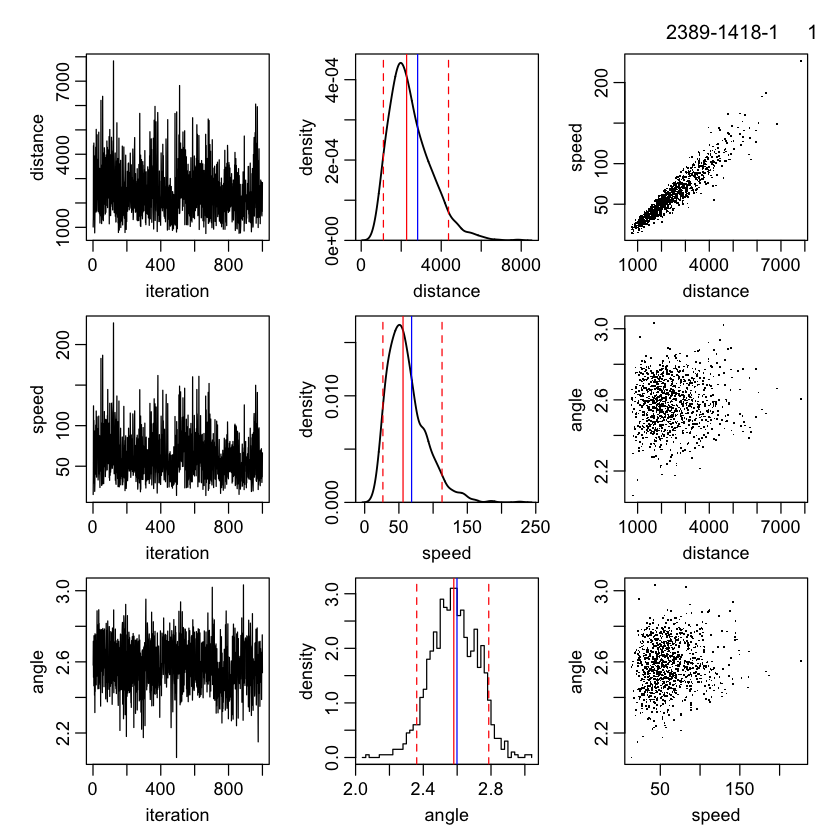

In [22]:
# Plot results
plot.mcmc(postSamp, phase3dNom, sqrt(diag(phase3dCov)), phase3dnames, sourcenames[n])